# Single photon & linear optics: Phase estimation

In [1]:
import itertools

import equinox as eqx
import jax
import jax.numpy as jnp
import seaborn as sns
import ultraplot as uplt
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.fock import BeamSplitter, FockState, Phase
from squint.utils import partition_op

In [2]:
cut = 4  # Fock cutoff
circuit = Circuit(backend="pure")
circuit.add(FockState(wires=(0,), n=(0,)))
circuit.add(FockState(wires=(1,), n=(1,)))

circuit.add(
    BeamSplitter(
        wires=(
            0,
            1,
        ),
        r=jnp.pi / 4,
    )
)
circuit.add(Phase(wires=(0,), phi=0.2 * jnp.pi), "phase")
circuit.add(
    BeamSplitter(
        wires=(
            0,
            1,
        ),
        r=jnp.pi / 4,
    )
)
pprint(circuit)

Circuit(
  dims=None,
  ops={
│   0:
│   FockState(wires=(0,), n=[(1.0, (0,))]),
│   1:
│   FockState(wires=(1,), n=[(1.0, (1,))]),
│   2:
│   BeamSplitter(wires=(0, 1), r=weak_f64[]),
│   'phase':
│   Phase(wires=(0,), phi=weak_f64[]),
│   4:
│   BeamSplitter(wires=(0, 1), r=weak_f64[])
  },
  _backend='pure'
)

In [3]:
params, static = partition_op(circuit, "phase")
sim = circuit.compile(static, 2, params, optimize="greedy")
pprint(static)

Circuit(
  dims=None,
  ops={
│   0:
│   FockState(wires=(0,), n=[(1.0, (0,))]),
│   1:
│   FockState(wires=(1,), n=[(1.0, (1,))]),
│   2:
│   BeamSplitter(wires=(0, 1), r=weak_f64[]),
│   'phase':
│   Phase(wires=(0,), phi=None),
│   4:
│   BeamSplitter(wires=(0, 1), r=weak_f64[])
  },
  _backend='pure'
)

In [4]:
ptol = sim.probabilities.forward(params).sum()
print("Total probability:", ptol)

Total probability: 1.0000000000000004


In [7]:
phis = jnp.linspace(-jnp.pi, jnp.pi, 100)
params = eqx.tree_at(lambda pytree: pytree.ops["phase"].phi, params, phis)

probs = jax.vmap(sim.probabilities.forward)(params)
grads = jax.vmap(sim.probabilities.grad)(params).ops["phase"].phi
qfims = jax.vmap(sim.amplitudes.qfim)(params)
cfims = jax.vmap(sim.probabilities.cfim)(params)

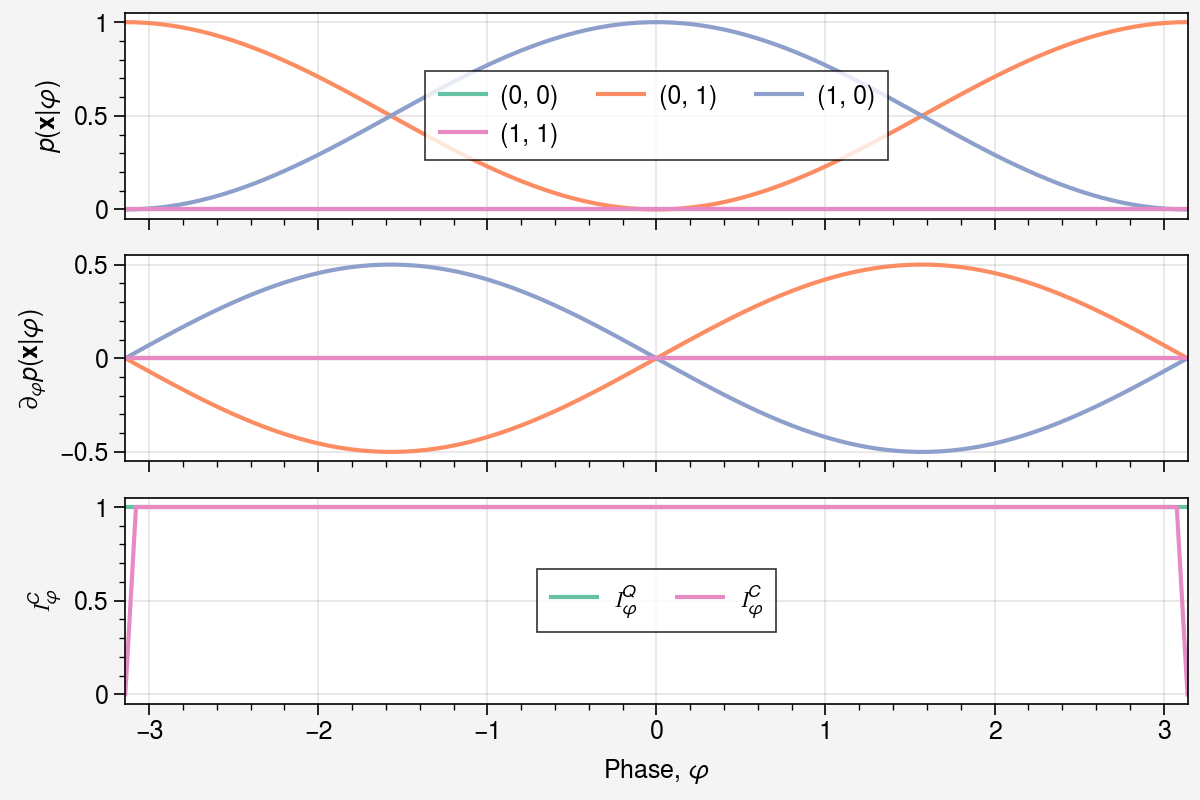

In [8]:
colors = sns.color_palette("Set2", n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, axs = uplt.subplots(nrows=3, figsize=(6, 4), sharey=False)

for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    axs[0].plot(phis, probs[:, *idx], label=f"{idx}", color=colors[i])

    axs[1].plot(phis, grads[:, *idx], label=f"{idx}", color=colors[i])
axs[0].legend()
axs[0].set(ylabel=r"$p(\mathbf{x} | \varphi)$")
axs[1].set(ylabel=r"$\partial_{\varphi} p(\mathbf{x} | \varphi)$")

axs[2].plot(phis, qfims.squeeze(), color=colors[0], label=r"$\mathcal{I}_\varphi^Q$")
axs[2].plot(phis, cfims.squeeze(), color=colors[-1], label=r"$\mathcal{I}_\varphi^C$")
axs[2].set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^C$",
    ylim=[-0.05, 1.05 * jnp.max(qfims)],
)
axs[2].legend();